# Selecting Rates from a Library

The `Library` class in `pynucastro` provides a high level interface for reading files containing one or more Reaclib rates and then filtering these rates based on user-specified criteria for the nuclei involved in the reactions. We can then use the resulting rates to build a network.

This example uses a Reaclib snapshot (`20180319default2`) downloaded from:

https://reaclib.jinaweb.org/library.php?action=viewsnapshots

That snapshot is found in the library search path.

## Reading a rate snapshot

The `Library` class will look for the library file in the working directory or in the `pynucastro/library` subdirectory of the `pynucastro` package.

When the constructor is supplied a file name, `pynucastro` will read the contents of this file and interpret them as Reaclib rates in either the Reaclib 1 or 2 formats. The `Library` then stores the rates from the file as `Rate` objects.

In [1]:
import pynucastro as pyna

In [2]:
mylibrary = pyna.ReacLibLibrary()

## Specifying Desired Nuclei

This example constructs a CNO network like the one constructed from a set of Reaclib rate files in the "pynucastro usage examples" section of this documentation.

This time, however, we will specify the nuclei we want in the network and allow the `Library` class to find all the rates linking only nuclei in the set we specified.

We can specify these nuclei by their abbreviations in the form, e.g. "he4":

In [3]:
all_nuclei = ["p", "he4", "c12", "n13", "c13", "o14", "n14", "o15", "n15"]

Now we use the `Library.linking_nuclei()` function to return a smaller `Library` object containing only the rates that link these nuclei.

We can pass `with_reverse=False` to restrict `linking_nuclei` to only include forward rates from the Reaclib library, as pynucastro does not yet implement partition functions for reverse rates.

In [4]:
cno_library = mylibrary.linking_nuclei(all_nuclei, with_reverse=False)

Now we can create a network (`PythonNetwork` or `StarKillerNetwork`) as:

In [5]:
cno_network = pyna.networks.PythonNetwork(libraries=cno_library)

In the above, we construct a network from a `Library` object by passing the `Library` object to the `libraries` argument of the network constructor. To construct a network from multiple libraries, the `libraries` argument can also take a list of `Library` objects.

We can show the structure of the network by plotting a network diagram.

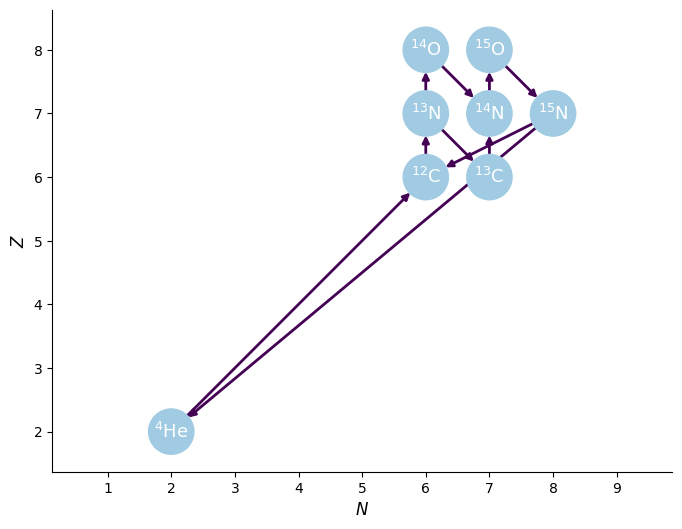

In [6]:
fig = cno_network.plot()

Note that the above network also includes the triple-alpha rate from Reaclib.

If we wanted to generate the python code to calculate the right-hand side we could next do:

In [7]:
cno_network.write_network('network_module.py')

And we could run this together with the burn driver program in `examples/burn.py`

## Filtering the Library

This example introduces the `RateFilter` class which allows us to define a set of reactants and products to search for in a `Library` object.

### Inexact Filtering

Inexact filtering is like using wildcards: in the following example, the rate filter we define will match any rates in which $\mathrm{^{12}C}$ is a reactant.

In [8]:
c12_inexact_filter = pyna.RateFilter(reactants=['c12'], exact=False)

Once we construct a `RateFilter` object, we can apply it to our `Library` by passing it to the `Library.filter` function.

`Library.filter` returns a new `Library` object containing the rates that match our `RateFilter`.

We can print a `Library` to see the rates it contains. In parentheses the rate identifier is printed, showing the Reaclib rate label as well as whether the rate is forward or reverse.

In [9]:
c12_inexact_library = mylibrary.filter(c12_inexact_filter)
print(c12_inexact_library)

C12 + n ⟶ C13 + 𝛾              [Q =   4.95 MeV] (C12 + n --> C13 <ks03_reaclib__>)
C12 + p ⟶ N13 + 𝛾              [Q =   1.94 MeV] (C12 + p --> N13 <ls09_reaclib__>)
C12 + He4 ⟶ O16 + 𝛾            [Q =   7.16 MeV] (C12 + He4 --> O16 <nac2_reaclib__>)
C12 + C12 ⟶ He4 + Ne20         [Q =   4.62 MeV] (C12 + C12 --> He4 + Ne20 <cf88_reaclib__>)
C12 + C12 ⟶ p + Na23           [Q =   2.24 MeV] (C12 + C12 --> p + Na23 <cf88_reaclib__>)
O16 + C12 ⟶ He4 + Mg24         [Q =   6.77 MeV] (O16 + C12 --> He4 + Mg24 <cf88_reaclib__>)
O16 + C12 ⟶ p + Al27           [Q =   5.17 MeV] (O16 + C12 --> p + Al27 <cf88_reaclib__>)
Ne20 + C12 ⟶ He4 + Si28        [Q =  12.02 MeV] (Ne20 + C12 --> He4 + Si28 <rolf_reaclib__>)
Ne20 + C12 ⟶ p + P31           [Q =  10.10 MeV] (Ne20 + C12 --> p + P31 <rolf_reaclib__>)
Ne20 + C12 ⟶ n + S31           [Q =   3.93 MeV] (Ne20 + C12 --> n + S31 <rolf_reaclib__>)
C12 + n ⟶ He4 + Be9            [Q =  -5.70 MeV] (C12 + n --> He4 + Be9 <cf88_reaclib__reverse>)
C12 + n ⟶ p + B1

The rate identifiers above can be used to access individual `Rate` objects within a `Library` as follows:

In [10]:
cago = c12_inexact_library.get_rate('c12 + he4 --> o16 <nac2_reaclib__>')

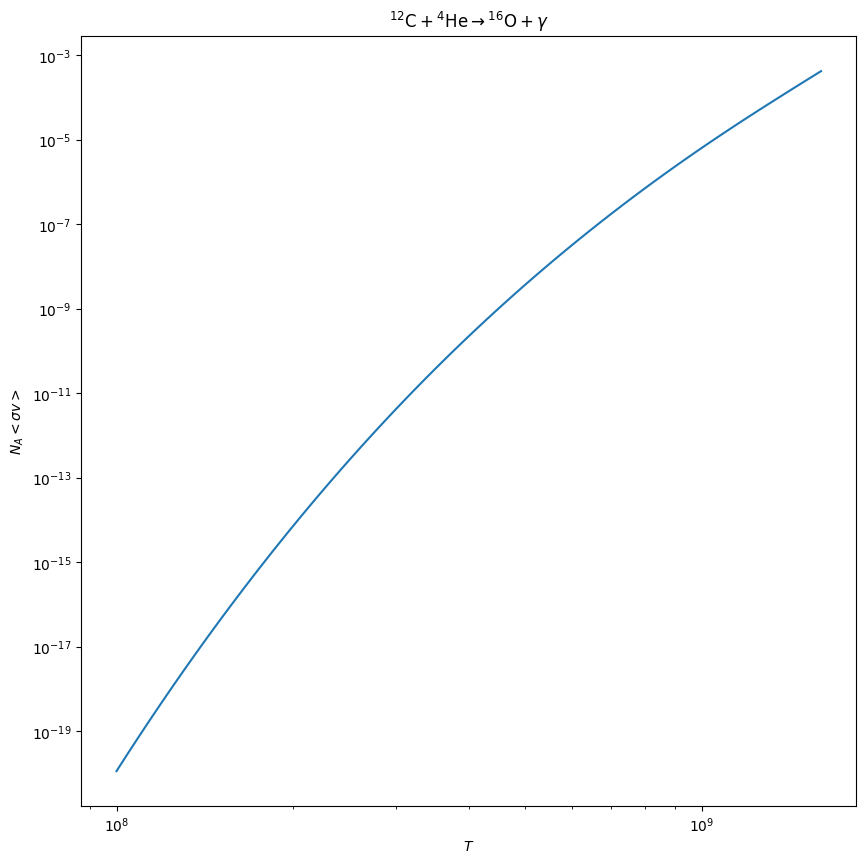

In [11]:
fig = cago.plot()

### Exact Filtering

Exact filtering is useful when you have a specific rate in mind or a specific combination of reactants or products. In the following example, we look for all rates of the form $\mathrm{^{12}C + ^{12}C \rightarrow \ldots}$

To use exact filtering, omit the `exact` keyword to the `RateFilter` constructor, as it is turned on by default.

Exact filtering does not mean all the nuclei involved in the rate must be specified, it means that all filtering options passed to the `RateFilter` constructor are strictly applied. In this case, the filter will return rates with exactly two reactants, both of which are $\mathrm{^{12}C}$. However, the filter places no constraint on the products or number of products in the rate.

In [12]:
c12_exact_filter = pyna.rates.RateFilter(reactants=['c12', 'c12'])
c12_exact_library = mylibrary.filter(c12_exact_filter)
print(c12_exact_library)

C12 + C12 ⟶ He4 + Ne20         [Q =   4.62 MeV] (C12 + C12 --> He4 + Ne20 <cf88_reaclib__>)
C12 + C12 ⟶ p + Na23           [Q =   2.24 MeV] (C12 + C12 --> p + Na23 <cf88_reaclib__>)
C12 + C12 ⟶ n + Mg23           [Q =  -2.60 MeV] (C12 + C12 --> n + Mg23 <cf88_reaclib__reverse>)


## Example: Building an Alpha Capture Network

In the next example, we use rate filtering to iteratively construct a `Library` containing the alpha capture rates linking $\mathrm{^{12}C}$ to $\mathrm{^{56}Ni}$.

After finding each successive link in the alpha capture chain, we call `Library.heaviest()` to find the heaviest nucleus in the filtered rates. This corresponds to the nucleus with the largest mass number, and in case of a tie between isobars, this returns the isobar with the smallest atomic number. We use this feature to find the reverse rate for each alpha capture reaction.

In the example below, we add each filtered library to our alpha capture library `alpha_library`, initialized as an empty `Library`. The `Library` class supports the addition operator by returning a new library containing the rates in the two libraries we added together.

This example also introduces the `max_products` keyword, which specifies we are looking for reactions producing at most `max_products` product nuclei.

Similarly, the `RateFilter` constructor supports the following keywords constraining the number of reactants and products:

- `min_reactants`
- `max_reactants`
- `min_products`
- `max_products`

Because we have omitted the argument `exact=False`, the filter constraints we apply are exact.

In [13]:
alpha_library = pyna.Library()

capture = pyna.Nucleus('he4')
seed = pyna.Nucleus('c12')

while True:
    ac_filter = pyna.RateFilter(reactants=[capture, seed], max_products=1)
    ac_library = mylibrary.filter(ac_filter)
    alpha_library = alpha_library + ac_library

    heavy = ac_library.heaviest()
    ac_filter_inv = pyna.RateFilter(reactants=[heavy], products=[capture, seed])
    ac_inv_library = mylibrary.filter(ac_filter_inv)
    alpha_library = alpha_library + ac_inv_library

    print(heavy)
    if heavy.A == 56:
        break
    else:
        seed = heavy

O16


Ne20


Mg24


Si28


S32


Ar36


Ca40


Ti44


Cr48


Fe52


Ni56


We will next print out the library we constructed, seeing that we have both forward and reverse rates for the alpha chain.

Note that at this time `pynucastro` has not yet implemented nuclear partition functions, so these reverse rates are calculated only from detailed balance in the Reaclib library.

In [14]:
print(alpha_library)

C12 + He4 ⟶ O16 + 𝛾            [Q =   7.16 MeV] (C12 + He4 --> O16 <nac2_reaclib__>)
O16 + He4 ⟶ Ne20 + 𝛾           [Q =   4.73 MeV] (O16 + He4 --> Ne20 <co10_reaclib__>)
Ne20 + He4 ⟶ Mg24 + 𝛾          [Q =   9.32 MeV] (Ne20 + He4 --> Mg24 <il10_reaclib__>)
Mg24 + He4 ⟶ Si28 + 𝛾          [Q =   9.98 MeV] (Mg24 + He4 --> Si28 <st08_reaclib__>)
Si28 + He4 ⟶ S32 + 𝛾           [Q =   6.95 MeV] (Si28 + He4 --> S32 <ths8_reaclib__>)
S32 + He4 ⟶ Ar36 + 𝛾           [Q =   6.64 MeV] (S32 + He4 --> Ar36 <ths8_reaclib__>)
Ar36 + He4 ⟶ Ca40 + 𝛾          [Q =   7.04 MeV] (Ar36 + He4 --> Ca40 <ths8_reaclib__>)
Ca40 + He4 ⟶ Ti44 + 𝛾          [Q =   5.13 MeV] (Ca40 + He4 --> Ti44 <chw0_reaclib__>)
Ti44 + He4 ⟶ Cr48 + 𝛾          [Q =   7.70 MeV] (Ti44 + He4 --> Cr48 <ths8_reaclib__>)
Cr48 + He4 ⟶ Fe52 + 𝛾          [Q =   7.94 MeV] (Cr48 + He4 --> Fe52 <ths8_reaclib__>)
Fe52 + He4 ⟶ Ni56 + 𝛾          [Q =   8.00 MeV] (Fe52 + He4 --> Ni56 <ths8_reaclib__>)
O16 ⟶ He4 + C12                [Q =  -7.16 MeV] 

Next we can create a reaction network from our filtered alpha capture library by passing our library to a network constructor using the `libraries` keyword.

In [15]:
alpha_network = pyna.PythonNetwork(libraries=alpha_library)

And finally we can make Z-N plot of the nuclei linked via the reactions we selected.

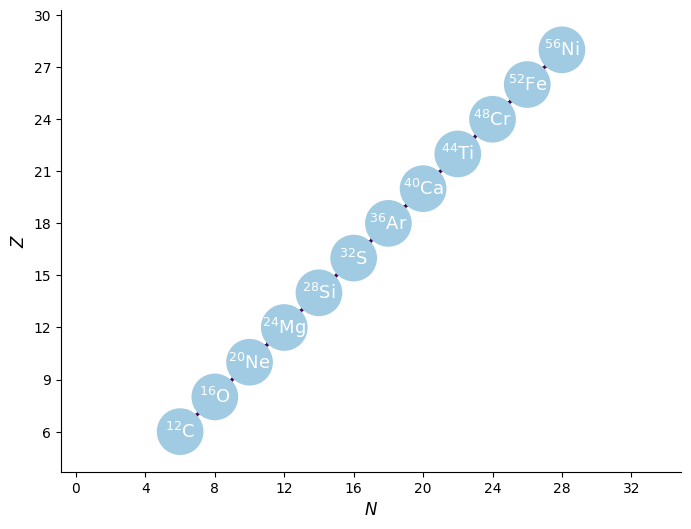

In [16]:
fig = alpha_network.plot()